In [1]:
import warnings
warnings.filterwarnings("ignore")
from glob import glob
import datetime
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
import seaborn, numpy, matplotlib.pyplot, pandas, plotly.express, pathlib, os, PIL, imageio, matplotlib.image
import sklearn 
from google.colab import drive
from scipy.signal import convolve2d

## Reading Database (Train and Valid)

In [2]:
try: 
  print("Mounting Directory from Google Drive\n")
  t1=float(str(datetime.datetime.now()).split(":")[-1])
  drive.mount('/content/drive')
  print("\nDirectory Mounted")
  t2=float(str(datetime.datetime.now()).split(":")[-1])
  print("\n Total Time taken: {} seconds".format(round((t2-t1),2)))
  drtrain='/content/drive/MyDrive/APOD_Train/'
  drval='/content/drive/MyDrive/APOD_Valid/'
except:
  print("Mounting Error! Probably Directory not Present")

Mounting Directory from Google Drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Directory Mounted

 Total Time taken: 3.36 seconds


## Image Count Visualiaation (Train and Valid)

In [ ]:
trpth=os.listdir(drtrain)
valpth=os.listdir(drval)
images1=[]
images2=[]
labels=['Fake','Real']
for i in trpth:
    images1.append(len(os.listdir(os.path.join(drtrain,i))))
for i in valpth:
    images2.append(len(os.listdir(os.path.join(drval,i))))
dfimg=pandas.DataFrame({"Type":labels,"Train_Img":images1,"Val_Img":images2})
drs=["Train","Validation"]
cls=dfimg.columns.tolist()[1:]
for cl in range(len(cls)):
    img_viz=plotly.express.bar(dfimg,x="Type",y="{}".format(cls[cl]),color="Type",text="{}".format(cls[cl]),
                               title="Images in {} Directory".format(drs[cl]),height=400,width=400)
    img_viz.update_layout(
        font=dict(
            family="Cambria, Bold",
            size=18,
            color="black"
        )
    )
    img_viz.show()

## Image Processing and Visualization

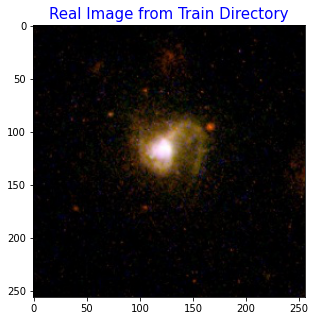

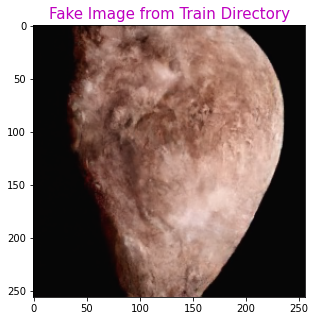

In [ ]:
train_dir = pathlib.Path(drtrain)
real_img_tr = list(train_dir.glob("Real/*"))
fake_img_tr = list(train_dir.glob("Fake/*"))
pictr1 = PIL.Image.open(real_img_tr[5])
matplotlib.pyplot.figure(figsize=(5,5))
matplotlib.pyplot.title("Real Image from Train Directory",fontsize=15,color="b")
matplotlib.pyplot.imshow(pictr1)
pictr2 = PIL.Image.open(fake_img_tr[7])
matplotlib.pyplot.figure(figsize=(5,5))
matplotlib.pyplot.title("Fake Image from Train Directory",fontsize=15,color="m")
matplotlib.pyplot.imshow(pictr2)

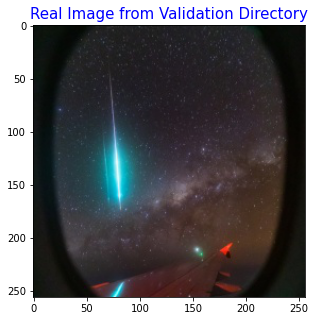

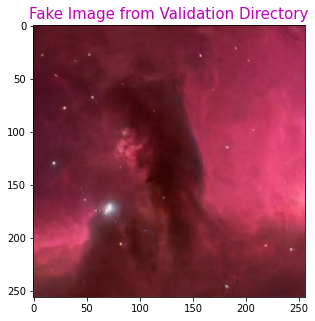

In [ ]:
val_dr = pathlib.Path(drval)
real_img_val = list(val_dr.glob("Real/*"))
fake_img_val = list(val_dr.glob("Fake/*"))
picval1 = PIL.Image.open(real_img_val[5])
matplotlib.pyplot.figure(figsize=(5,5))
matplotlib.pyplot.title("Real Image from Validation Directory",fontsize=15,color="b")
matplotlib.pyplot.imshow(picval1)
picval2 = PIL.Image.open(fake_img_val[5])
matplotlib.pyplot.figure(figsize=(5,5))
matplotlib.pyplot.title("Fake Image from Validation Directory",fontsize=15,color="m")
matplotlib.pyplot.imshow(picval2)

## Parameter Settings

In [ ]:
bt_size = 32
hgt = 96
wdh = 96
img_classes=os.listdir(drtrain)
print(img_classes)

['Fake', 'Real']


## Feature Extraction

In [ ]:
traingen = keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255,
                                   rotation_range=90,
                                   shear_range=0.2,
                                   zoom_range=0.3,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   vertical_flip=True,
                                   horizontal_flip=True)
valgen = keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255)

In [ ]:
train_data = traingen.flow_from_directory(drtrain,classes=img_classes,target_size=(hgt, wdh),batch_size=bt_size,class_mode='categorical')
print(numpy.unique(train_data.classes))

Found 7000 images belonging to 2 classes.
[0 1]


In [ ]:
val_data = valgen.flow_from_directory(drval,classes=img_classes,target_size=(hgt, wdh),batch_size=bt_size,class_mode='categorical')
print(numpy.unique(val_data.classes))

Found 2183 images belonging to 2 classes.
[0 1]


## Neural Network Model Preparation

In [ ]:
#layers.experimental.preprocessing.Rescaling(1./255),
deepCNN = models.Sequential([
    layers.Conv2D(16,3, padding = "same", activation = "relu"),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Conv2D(32,3, padding = "same", activation = "relu"),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Conv2D(64,3, padding = "same", activation = "relu"),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Conv2D(128,3, padding = "same", activation = "relu"),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Conv2D(256,3, padding = "same", activation = "relu"),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128,activation = "relu"),
    layers.Flatten(),
    layers.Dense(2),
    layers.Activation('softmax')
])

deepCNN.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy']) 
epochs=100
CNNHist = deepCNN.fit(train_data,batch_size=32,validation_data=val_data,verbose=1,epochs=epochs)
deepCNN.summary()

Epoch 1/100
219/219 [==============================] - 40s 181ms/step - loss: 0.4796 - accuracy: 0.7541 - val_loss: 0.4745 - val_accuracy: 0.7778
Epoch 2/100
219/219 [==============================] - 39s 180ms/step - loss: 0.3762 - accuracy: 0.8217 - val_loss: 0.5687 - val_accuracy: 0.7609
Epoch 3/100
219/219 [==============================] - 39s 178ms/step - loss: 0.3768 - accuracy: 0.8210 - val_loss: 0.4012 - val_accuracy: 0.8140
Epoch 4/100
219/219 [==============================] - 38s 175ms/step - loss: 0.3336 - accuracy: 0.8479 - val_loss: 0.4273 - val_accuracy: 0.8044
Epoch 5/100
219/219 [==============================] - 38s 176ms/step - loss: 0.3367 - accuracy: 0.8469 - val_loss: 0.5053 - val_accuracy: 0.7911
Epoch 6/100
219/219 [==============================] - 38s 174ms/step - loss: 0.3220 - accuracy: 0.8514 - val_loss: 0.3863 - val_accuracy: 0.8351
Epoch 7/100
219/219 [==============================] - 39s 179ms/step - loss: 0.3113 - accuracy: 0.8564 - val_loss: 0.4231 -

In [ ]:
deepCNN.evaluate(train_data)

219/219 [==============================] - 34s 153ms/step - loss: 0.2077 - accuracy: 0.9043


[0.20765647292137146, 0.904285728931427]

In [ ]:
deepCNN.evaluate(val_data)

69/69 [==============================] - 7s 103ms/step - loss: 0.5740 - accuracy: 0.8301


[0.5739988088607788, 0.8300504088401794]

In [ ]:
def ImgShow(crimg,dr,pr):
    matplotlib.pyplot.figure(figsize=(8,4))
    picdcted=imageio.imread(crimg)
    matplotlib.pyplot.title("\nActual => {} \nDetected => {}".format(dr,pr),fontsize=16,color="b")
    matplotlib.pyplot.imshow(picdcted)
    matplotlib.pyplot.axis('off')
    matplotlib.pyplot.show()
def DetectRF(crimg,dr,mdl):
    rfpic = keras.preprocessing.image.load_img(crimg,target_size=(hgt,wdh))
    rfpic = keras.preprocessing.image.img_to_array(rfpic)
    rfpic = numpy.expand_dims(rfpic,axis=0)
    dcted=mdl.predict(rfpic)
    dcted_1=numpy.argmax(dcted, axis=1)
    if dcted_1[0]==1:
      ImgShow(crimg,dr,"Real")
    elif dcted_1[0]==0:
      ImgShow(crimg,dr,"Fake")

['Fake', 'Real']
1/1 [==============================] - 0s 16ms/step


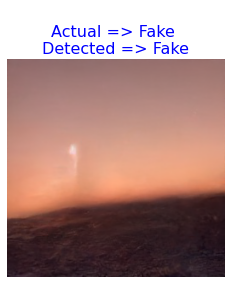

1/1 [==============================] - 0s 16ms/step


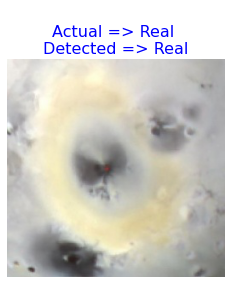

In [ ]:
drcls=os.listdir(drval)
print(drcls)
crimg=os.path.join(drval,drcls[0],os.listdir(drval+"/"+drcls[0])[27])
DetectRF(crimg,drcls[0],deepCNN)
crimg=os.path.join(drval,drcls[1],os.listdir(drval+"/"+drcls[1])[115])
DetectRF(crimg,drcls[1],deepCNN)

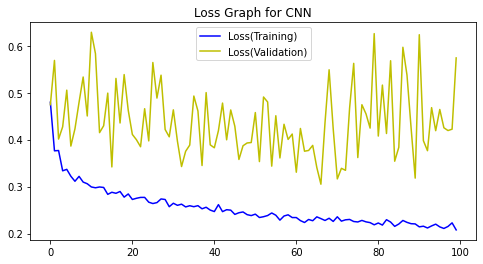

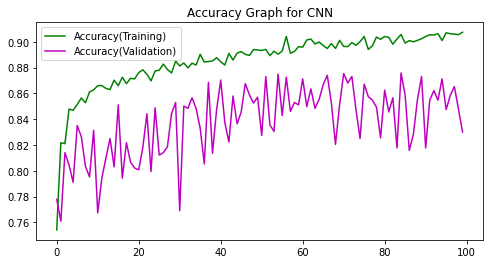

In [ ]:
cnnresdf=pandas.DataFrame({
    "Iteration":["{}".format(x) for x in range(100)],
    "Loss(Training)":CNNHist.history['loss'],
    "Loss(Validation)":CNNHist.history['val_loss'],
    "Accuracy(Training)":CNNHist.history['accuracy'],
    "Accuracy(Validation)":CNNHist.history['val_accuracy']
})
cnnresdf.to_csv("CNN_Result.csv")
cnnresdf.iloc[:,1:3].plot(kind='line',title="Loss Graph for CNN",figsize=(8,4),color=["b","y"])
cnnresdf.iloc[:,3:].plot(kind='line',title="Accuracy Graph for CNN",figsize=(8,4),color=["g","m"])




In [ ]:
deepCNN.save("deepCNN.h5")